In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, utils
import matplotlib.pyplot as plt

In [22]:
batch_size = 32
img_height = 75
img_width = 75

In [23]:
def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (75, 75))
            images.append(img)
            labels.append(label)
    return images, labels

categories = {
    "down": 0,
    "neutral": 1,
    "up": 2,
    "other": 3
}


X = []
y = []

for category, label in categories.items():
    folder_path = os.path.join("../generator/data/train/", category)
    images, labels = load_images_from_folder(folder_path, label)
    X.extend(images)
    y.extend(labels)

X = np.array(X)
y = np.array(y)

# # Normalize the images to values between 0 and 1
X = X.astype("float32") / 255.0
X

array([[[[0.        , 1.        , 0.        ],
         [0.        , 1.        , 0.        ],
         [0.        , 1.        , 0.        ],
         ...,
         [0.        , 1.        , 0.        ],
         [0.        , 1.        , 0.        ],
         [0.        , 1.        , 0.        ]],

        [[0.        , 1.        , 0.        ],
         [0.09411765, 0.27058825, 0.49019608],
         [0.09019608, 0.2784314 , 0.49803922],
         ...,
         [0.17254902, 0.41960785, 0.6862745 ],
         [0.16862746, 0.42352942, 0.69411767],
         [0.1254902 , 0.5176471 , 0.57254905]],

        [[0.        , 1.        , 0.        ],
         [0.13333334, 0.26666668, 0.49803922],
         [0.10196079, 0.26666668, 0.5019608 ],
         ...,
         [0.18039216, 0.43137255, 0.6862745 ],
         [0.18039216, 0.43529412, 0.6901961 ],
         [0.13725491, 0.5294118 , 0.5568628 ]],

        ...,

        [[0.        , 1.        , 0.        ],
         [0.07843138, 0.25490198, 0.47843137]

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = utils.to_categorical(y_train, len(categories))
y_test = utils.to_categorical(y_test, len(categories))

# Step 2: Create the deep learning model for gesture detection

def create_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(num_classes, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Define the input shape and number of classes (gestures)
input_shape = X_train[0].shape
num_classes = len(categories)

# Create the model
model = create_model(input_shape, num_classes)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 73, 73, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 17, 17, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 7, 7, 128)        

In [25]:
# Train the model

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Load and preprocess the test dataset

X_test = []
y_test = []

for category, label in categories.items():
    folder_path = os.path.join("../generator/data/test/", category)
    images, labels = load_images_from_folder(folder_path, label)
    X_test.extend(images)
    y_test.extend(labels)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.astype("float32") / 255.0
y_test = utils.to_categorical(y_test, len(categories))

print()
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)


Epoch 1/20
39/39 [==============================] - 3s 64ms/step - loss: 1.2599 - accuracy: 0.3955 - val_loss: 1.0889 - val_accuracy: 0.5691
Epoch 2/20
39/39 [==============================] - 2s 62ms/step - loss: 0.9405 - accuracy: 0.6077 - val_loss: 0.8892 - val_accuracy: 0.6013
Epoch 3/20
39/39 [==============================] - 2s 61ms/step - loss: 0.6859 - accuracy: 0.7130 - val_loss: 0.6368 - val_accuracy: 0.7428
Epoch 4/20
39/39 [==============================] - 2s 60ms/step - loss: 0.4814 - accuracy: 0.8183 - val_loss: 0.5264 - val_accuracy: 0.7814
Epoch 5/20
39/39 [==============================] - 2s 59ms/step - loss: 0.4099 - accuracy: 0.8432 - val_loss: 0.4603 - val_accuracy: 0.8264
Epoch 6/20
39/39 [==============================] - 2s 60ms/step - loss: 0.3124 - accuracy: 0.8834 - val_loss: 0.4037 - val_accuracy: 0.8296
Epoch 7/20
39/39 [==============================] - 2s 59ms/step - loss: 0.2461 - accuracy: 0.9172 - val_loss: 0.3669 - val_accuracy: 0.8553
Epoch 8/20
39

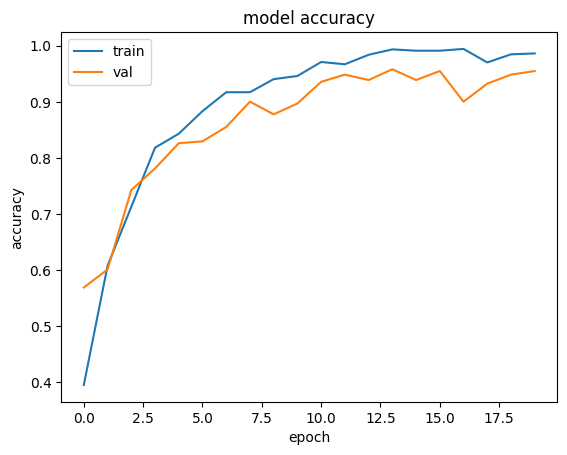

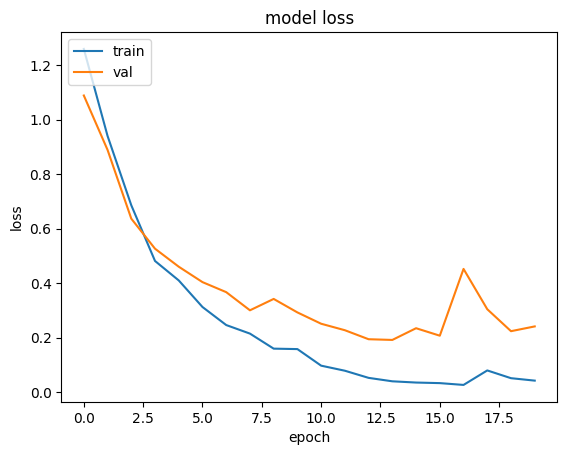

In [26]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
from tensorflow.keras.models import save_model, load_model

# Save the trained model
model.save("gesture_detection_model.h5")

/home/ansah/Documents/Programming/Projects/gesture-scroll/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


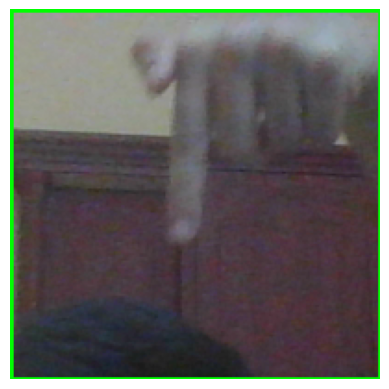

1/1 [==============================] - 0s 16ms/step
[[9.9998534e-01 3.0785998e-06 2.2865419e-07 1.1396749e-05]]
Predicted gesture label with the second largest probability: other


In [35]:
image_path = "../generator/data/train/down/hand_1690112642.3022504_207.png"
img = cv2.imread(image_path)

# Convert BGR to RGB for correct colors
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis("off")  # Hide the axis ticks and labels
plt.show()

img = cv2.resize(img, (75, 75))
img = img.astype("float32") / 255.0
img = np.expand_dims(img, axis=0)  # Add a batch dimension

# Make predictions on the image using the pre-trained model (assuming 'model' is defined)
predicted_probabilities = model.predict(img)
print(predicted_probabilities)

# Get the index of the second largest probability
second_largest_index = np.argsort(predicted_probabilities[0])[-2]

# Get the label from the categories dictionary (assuming 'categories' is defined)
gesture_label = None
for label, value in categories.items():
    if value == second_largest_index:
        gesture_label = label
        break

print("Predicted gesture label with the second largest probability:", gesture_label)


In [ ]:
# # Load the saved model
# loaded_model = load_model("gesture_detection_model.h5")